# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%load_ext tensorboard
%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 5
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:100]
test_paths = glob('../dataset/cifar/test/*.png')[:100]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training

In [14]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

C:\Users\pmcsh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
3/3 [==============================] - 15s 2s/step - loss: 2.3691 - accuracy: 0.1393 - val_loss: 2.2877 - val_accuracy: 0.1771
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.3348 - accuracy: 0.0972 - val_loss: 2.3072 - val_accuracy: 0.0729
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 2.3017 - accuracy: 0.0938 - val_loss: 2.3182 - val_accuracy: 0.0729
Epoch 4/5
3/3 [==============================] - 3s 2s/step - loss: 2.2549 - accuracy: 0.2112 - val_loss: 2.3428 - val_accuracy: 0.0729
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 2.1888 - accuracy: 0.2112 - val_loss: 2.3705 - val_accuracy: 0.0729


# Predict

### 이미지를 Load 직접 load해서 넣는 방법

In [15]:
path = test_paths[0]
path

'../dataset/cifar/test\\0_cat.png'

In [16]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype = tf.float32)
image.shape

TensorShape([32, 32, 3])

In [17]:
image = image[tf.newaxis,...]

In [18]:
image.shape

TensorShape([1, 32, 32, 3])

In [19]:
pred = model.predict(image)

In [20]:
pred.shape

(1, 10)

In [21]:
pred

array([[0.10021349, 0.07867616, 0.14109306, 0.08769843, 0.10723352,
        0.06175027, 0.09544268, 0.08996507, 0.15589154, 0.08203584]],
      dtype=float32)

In [22]:
np.argmax(pred)

8

### generator에서 데이터를 가져오는 방법

In [24]:
test_image, test_label = next(iter(test_dataset))

In [25]:
test_image.shape

TensorShape([32, 32, 32, 3])

In [26]:
pred = model.predict(test_image)

In [27]:
pred.shape

(32, 10)

In [28]:
pred[0]

array([0.10021349, 0.07867616, 0.14109306, 0.08769843, 0.10723352,
       0.06175026, 0.09544268, 0.08996507, 0.15589154, 0.08203584],
      dtype=float32)

In [29]:
np.argmax(pred[0])

8

### generator에 넣는 방법

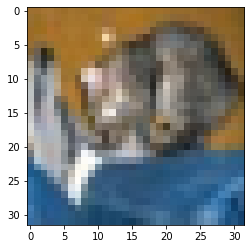

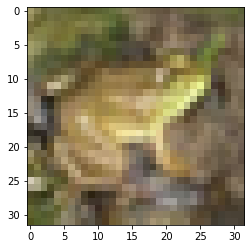

In [32]:
for image, label in test_dataset.take(2):
    plt.imshow(image[0])
    plt.show()

In [33]:
pred = model.predict_generator(test_dataset.take(2))

In [34]:
pred.shape

(64, 10)

In [35]:
image, label =next(iter(test_dataset))

In [36]:
image.shape

TensorShape([32, 32, 32, 3])

In [37]:
evals = model.evaluate(image, label)

1/1 [==============================] - 0s 466ms/step - loss: 2.3848 - accuracy: 0.1250


In [38]:
evals

[2.3848352432250977, 0.125]